
LOADING AND PREPROCESSING GERMAN CREDIT DATASET
✓ German Credit loaded: (1000, 21)
  checking_status  duration credit_history purpose  credit_amount  \
0             A11         6            A34     A43           1169   
1             A12        48            A32     A43           5951   
2             A14        12            A34     A46           2096   
3             A11        42            A32     A42           7882   
4             A11        24            A33     A40           4870   

  savings_status employment  installment_commitment personal_status  \
0            A65        A75                       4             A93   
1            A61        A73                       2             A92   
2            A61        A74                       2             A93   
3            A61        A74                       2             A93   
4            A61        A73                       3             A93   

  other_parties  ...  property_magnitude age  other_payment_plans housing 

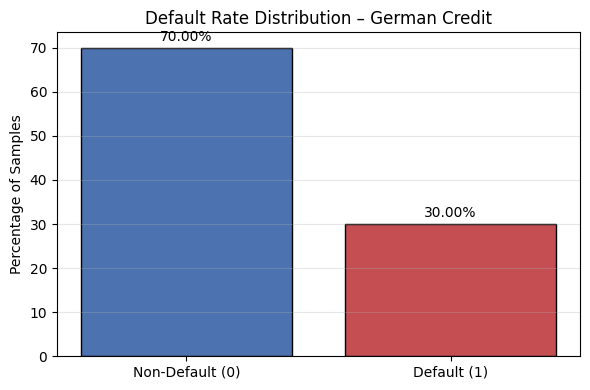


Categorical columns (13): ['checking_status', 'credit_history', 'purpose', 'savings_status', 'employment', 'personal_status', 'other_parties', 'property_magnitude', 'other_payment_plans', 'housing', 'job', 'own_telephone', 'foreign_worker']
Numeric columns (7): ['duration', 'credit_amount', 'installment_commitment', 'residence_since', 'age', 'existing_credits', 'num_dependents']

Number of processed features: 48
First 10 feature names: ['cat__checking_status_A12' 'cat__checking_status_A13'
 'cat__checking_status_A14' 'cat__credit_history_A31'
 'cat__credit_history_A32' 'cat__credit_history_A33'
 'cat__credit_history_A34' 'cat__purpose_A41' 'cat__purpose_A410'
 'cat__purpose_A42']

=== Tuning RF ===
Fitting 4 folds for each of 15 candidates, totalling 60 fits
Best RF AUC: 0.7871
Best params: {'clf__n_estimators': 250, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_features': 'sqrt', 'clf__max_depth': 8, 'clf__class_weight': 'balanced'}

=== Tuning XGB ===
Fitting 4 

In [1]:
# ============================================================
# 0. SETUP
# ============================================================
import warnings
warnings.filterwarnings('ignore')

!pip install --quiet xgboost lightgbm imbalanced-learn shap networkx seaborn numba scikit_posthocs

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import StratifiedKFold, train_test_split, RandomizedSearchCV
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import roc_auc_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.base import clone
from sklearn.utils.class_weight import compute_class_weight
from sklearn.pipeline import Pipeline

import xgboost as xgb
import lightgbm as lgb

from imblearn.over_sampling import SMOTE
from imblearn.combine import SMOTETomek
from imblearn.pipeline import Pipeline as ImbPipeline

import shap
import networkx as nx
from sklearn.cluster import AgglomerativeClustering
from scipy.spatial.distance import cosine

import scikit_posthocs as sp
from scipy.stats import friedmanchisquare, wilcoxon, spearmanr, kendalltau

import os

plt.style.use('default')
sns.set_palette("deep")
np.random.seed(42)
RANDOM_STATE = 42

# ============================================================
# 1. LOAD DATA + DEFAULT DISTRIBUTION PLOT (GERMAN CREDIT)
# ============================================================

print("\n" + "="*80)
print("LOADING AND PREPROCESSING GERMAN CREDIT DATASET")
print("="*80)

url = "https://archive.ics.uci.edu/ml/machine-learning-databases/statlog/german/german.data"
cols = ['checking_status','duration','credit_history','purpose','credit_amount',
        'savings_status','employment','installment_commitment','personal_status',
        'other_parties','residence_since','property_magnitude','age',
        'other_payment_plans','housing','existing_credits','job',
        'num_dependents','own_telephone','foreign_worker','target']

df = pd.read_csv(url, sep=' ', header=None, names=cols)
df['target'] = df['target'].map({1: 0, 2: 1})  # 1=good(0), 2=bad(1)

print("✓ German Credit loaded:", df.shape)
print(df.head())
print(df.info())

# Default distribution
default_counts = df['target'].value_counts().sort_index()
default_pct = default_counts / len(df) * 100

print("\nDefault distribution:")
print(default_counts)
print(default_pct.round(2))

plt.figure(figsize=(6, 4))
bars = plt.bar(
    ['Non‑Default (0)', 'Default (1)'],
    default_pct.values,
    color=['#4C72B0', '#C44E52'],
    edgecolor='black'
)
plt.bar_label(bars, fmt="%.2f%%", padding=3)
plt.ylabel("Percentage of Samples")
plt.title("Default Rate Distribution – German Credit")
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# ============================================================
# 2. PREPROCESSING
# ============================================================

X = df.drop(columns=['target'])
y = df['target']

cat_cols = X.select_dtypes(include=['object']).columns.tolist()
num_cols = X.select_dtypes(include=['int64', 'float64']).columns.tolist()

print(f"\nCategorical columns ({len(cat_cols)}): {cat_cols}")
print(f"Numeric columns ({len(num_cols)}): {num_cols}")

cat_categories = [sorted(X[col].dropna().unique().tolist()) for col in cat_cols]

preprocessor = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first',
                          handle_unknown='ignore',
                          sparse_output=False,
                          categories=cat_categories), cat_cols),
    ('num', StandardScaler(), num_cols)
])

X_processed = preprocessor.fit_transform(X)
feature_names = preprocessor.get_feature_names_out()
d = X_processed.shape[1]

print(f"\nNumber of processed features: {d}")
print("First 10 feature names:", feature_names[:10])

# ============================================================
# 3. RANDOMIZED HYPERPARAMETER TUNING (GERMAN)
# ============================================================

def tune_model(X, y, model_name="RF", n_iter=15):
    print(f"\n=== Tuning {model_name} ===")

    numeric = X.select_dtypes(include=np.number).columns.tolist()
    cat     = X.select_dtypes(exclude=np.number).columns.tolist()

    prep = ColumnTransformer([
        ('cat', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False), cat),
        ('num', StandardScaler(), numeric)
    ], remainder='passthrough')

    if model_name == "RF":
        base_model = RandomForestClassifier(random_state=RANDOM_STATE, n_jobs=-1)
        param_dist = {
            'clf__n_estimators':     [80, 120, 160, 200, 250],
            'clf__max_depth':        [4, 6, 8, 10, None],
            'clf__min_samples_split':[2, 5, 10],
            'clf__min_samples_leaf': [1, 2, 4],
            'clf__max_features':     ['sqrt', 'log2', 0.6],
            'clf__class_weight':     ['balanced', None]
        }

    elif model_name == "XGB":
        base_model = xgb.XGBClassifier(random_state=RANDOM_STATE, eval_metric='auc', verbosity=0)
        param_dist = {
            'clf__n_estimators':     [80, 120, 180, 250],
            'clf__learning_rate':    [0.008, 0.02, 0.05, 0.12],
            'clf__max_depth':        [3, 4, 6, 8],
            'clf__subsample':        [0.65, 0.8, 0.95],
            'clf__colsample_bytree': [0.6, 0.8, 1.0],
            'clf__reg_lambda':       [0.1, 1, 5],
            'clf__scale_pos_weight': [1, 2, 3, 5]
        }

    elif model_name == "LGB":
        base_model = lgb.LGBMClassifier(random_state=RANDOM_STATE, verbose=-1)
        param_dist = {
            'clf__n_estimators':     [80, 120, 180, 250],
            'clf__learning_rate':    [0.008, 0.02, 0.05, 0.12],
            'clf__max_depth':        [3, 4, 6, 8],
            'clf__num_leaves':       [20, 40, 80, 150],
            'clf__subsample':        [0.65, 0.8, 0.95],
            'clf__colsample_bytree': [0.6, 0.8, 1.0],
            'clf__reg_lambda':       [0.1, 1, 5],
            'clf__class_weight':     ['balanced', None]
        }

    pipe = Pipeline([('prep', prep), ('clf', base_model)])

    search = RandomizedSearchCV(
        pipe, param_distributions=param_dist,
        n_iter=n_iter,
        cv=StratifiedKFold(4, shuffle=True, random_state=RANDOM_STATE),
        scoring='roc_auc',
        n_jobs=-1,
        random_state=RANDOM_STATE,
        verbose=1
    )

    y_clean = y.values.astype(np.int64)
    search.fit(X, y_clean)

    print(f"Best {model_name} AUC: {search.best_score_:.4f}")
    print("Best params:", search.best_params_)

    return search.best_estimator_, search.best_params_, search.best_score_

y_tune = df['target'].astype(np.int64)
X_tune = df.drop(columns=['target'])

best_rf, rf_params, rf_auc = tune_model(X_tune, y_tune, "RF", n_iter=15)
best_xgb, xgb_params, xgb_auc = tune_model(X_tune, y_tune, "XGB", n_iter=15)
best_lgb, lgb_params, lgb_auc = tune_model(X_tune, y_tune, "LGB", n_iter=15)

print("\nBest parameters for thesis table (German):")
print("RF:", rf_params)
print("XGB:", xgb_params)
print("LGB:", lgb_params)

# Extract bare classifier params for later use
def strip_prefix(d, prefix="clf__"):
    return {k[len(prefix):]: v for k, v in d.items() if k.startswith(prefix)}

BEST_PARAMS = {
    'RF':  strip_prefix(rf_params),
    'XGB': strip_prefix(xgb_params),
    'LGB': strip_prefix(lgb_params)
}

BEST_PARAMS['RF'].update({'random_state': RANDOM_STATE, 'n_jobs': -1})
BEST_PARAMS['XGB'].update({'random_state': RANDOM_STATE, 'eval_metric': 'auc', 'verbosity': 0})
BEST_PARAMS['LGB'].update({'random_state': RANDOM_STATE, 'verbose': -1})

models = {
    'RF': RandomForestClassifier(**BEST_PARAMS['RF']),
    'XGB': xgb.XGBClassifier(**BEST_PARAMS['XGB']),
    'LGB': lgb.LGBMClassifier(**BEST_PARAMS['LGB'])
}

print("\nBEST MODEL CONFIGURATION (German):")
for mname, m in models.items():
    print(f"\n[{mname}]")
    print(m.get_params())

# ============================================================
# 3.1 RESAMPLERS
# ============================================================

resamplers = {
    'None': None,
    'SMOTE': SMOTE(random_state=42),
    'SMOTETomek': SMOTETomek(random_state=42),
    'CostSensitive': 'cost'
}

class_weight_dict = {
    int(cls): float(w)
    for cls, w in zip(np.unique(y), compute_class_weight('balanced', classes=np.unique(y), y=y))
}

print("\nClass weights (for CostSensitive):", class_weight_dict)

# ============================================================
# 4. DOMAIN GROUPS (BASEL‑ALIGNED – GERMAN CREDIT)
# ============================================================

def build_domain_groups_german(fnames):
    groups = {
        "ObligorCharacteristics": [],
        "Creditworthiness": [],
        "ContractTerms": [],
        "CollateralSupport": [],
        "LoanMetadata": []
    }

    for i, name in enumerate(fnames):
        lname = name.lower()

        if any(k in lname for k in [
            "age", "personal_status", "job",
            "num_dependents", "residence_since"
        ]):
            groups["ObligorCharacteristics"].append(i)

        elif any(k in lname for k in [
            "credit_history", "existing_credits",
            "employment", "savings_status"
        ]):
            groups["Creditworthiness"].append(i)

        elif any(k in lname for k in [
            "duration", "credit_amount",
            "installment_commitment"
        ]):
            groups["ContractTerms"].append(i)

        elif any(k in lname for k in [
            "property_magnitude", "housing",
            "other_parties"
        ]):
            groups["CollateralSupport"].append(i)

        elif any(k in lname for k in [
            "purpose", "own_telephone", "foreign_worker",
            "other_payment_plans"
        ]):
            groups["LoanMetadata"].append(i)

    return {g: v for g, v in groups.items() if len(v) > 0}

domain_groups = build_domain_groups_german(feature_names)

print("\nBasel‑aligned domain groups (German Credit):")
for g, feats in domain_groups.items():
    print(f"  {g}: {len(feats)} features")

# ============================================================
# 5. EXPLANATION METHODS
# ============================================================

def stratified_explanation_sample(X_te, y_te, n=30, random_state=42, min_pos=5):
    X_te = X_te.reset_index(drop=True)
    y_te = pd.Series(y_te).reset_index(drop=True)

    n = min(n, len(X_te))

    pos_idx = y_te[y_te == 1].index
    neg_idx = y_te[y_te == 0].index

    n_pos = min(min_pos, len(pos_idx), n)
    n_neg = n - n_pos

    X_pos = X_te.loc[pos_idx].sample(n=n_pos, random_state=random_state) if n_pos > 0 else X_te.iloc[0:0]
    X_neg = X_te.loc[neg_idx].sample(n=n_neg, random_state=random_state) if n_neg > 0 else X_te.iloc[0:0]

    X_sample = pd.concat([X_pos, X_neg]).sample(frac=1, random_state=random_state)
    return X_sample

def get_shap_reliable(pipe, X_test, max_instances=30, random_state=42):
    clf = pipe.named_steps['clf']

    if len(X_test) > max_instances:
        X_shap = X_test.sample(
            n=max_instances,
            random_state=random_state,
            replace=False
        )
    else:
        X_shap = X_test.copy()

    X_proc = pipe.named_steps['prep'].transform(X_shap)

    try:
        explainer = shap.TreeExplainer(clf)
        sv = explainer.shap_values(X_proc)

        if isinstance(sv, list):
            return sv[1]
        elif sv.ndim == 3:
            return sv[:, :, 1]
        else:
            return sv

    except Exception as e:
        print(f"  SHAP failed: {e}")
        n_features = X_proc.shape[1]
        return np.zeros((len(X_shap), n_features))

def compute_banzhaf(pipe, X_test, n_samples=2, max_instances=2):
    clf = pipe.named_steps['clf']
    X_proc = pipe.named_steps['prep'].transform(X_test)
    n_feat = X_proc.shape[1]
    n_inst = min(max_instances, X_proc.shape[0])
    mat = np.zeros((n_inst, n_feat))

    for i in range(n_inst):
        x = X_proc[i:i+1]
        for f in range(n_feat):
            contrib = []
            for _ in range(n_samples):
                coal = np.random.binomial(1, 0.5, n_feat)
                x_with = x.copy()
                x_with[0, f] = x[0, f] * coal[f]
                p1 = clf.predict_proba(x_with)[0, 1]

                x_without = x.copy()
                x_without[0, f] = 0
                p0 = clf.predict_proba(x_without)[0, 1]

                contrib.append(p1 - p0)
            mat[i, f] = np.mean(contrib)
    return mat

def compute_myerson(pipe, X_test, G, alpha=0.5):
    shap_vals = get_shap_reliable(pipe, X_test, max_instances=30)
    shap_mean = shap_vals.mean(axis=0)
    d_local = len(shap_mean)
    phi = np.zeros(d_local)

    for i in range(d_local):
        neighbors = list(G.neighbors(i)) if i in G.nodes() else []
        if len(neighbors) == 0:
            phi[i] = shap_mean[i]
        else:
            neighbor_mean = np.mean([shap_mean[j] for j in neighbors if j < d_local])
            phi[i] = (1 - alpha) * shap_mean[i] + alpha * neighbor_mean

    return np.tile(phi, (min(30, len(X_test)), 1)), shap_vals, shap_mean

def build_data_groups(X_proc, n_groups=5):
    try:
        X_proc = np.nan_to_num(X_proc, nan=0.0)
        with np.errstate(invalid='ignore'):
            corr = np.corrcoef(X_proc.T)
        corr = np.nan_to_num(corr, nan=0.0)
        np.fill_diagonal(corr, 1.0)
        dist = 1 - np.abs(corr)
        dist = np.clip(dist, 0.0, 2.0)

        if X_proc.shape[1] < n_groups:
            n_groups = max(2, X_proc.shape[1] // 2)

        clustering = AgglomerativeClustering(
            n_clusters=n_groups, metric='precomputed', linkage='average'
        )
        labels = clustering.fit_predict(dist)

        groups = {}
        for idx, lab in enumerate(labels):
            groups.setdefault(f"Data_Cluster_{lab}", []).append(idx)
        return groups, np.abs(corr)
    except Exception as e:
        print(f"  Data-driven grouping failed: {e}")
        n_features = X_proc.shape[1]
        return {"Data_Default": list(range(n_features))}, np.eye(n_features)

def build_model_groups(shap_vals, n_groups=5):
    try:
        shap_vals = np.nan_to_num(shap_vals, nan=0.0)
        if shap_vals.ndim == 1:
            shap_vals = shap_vals.reshape(1, -1)
        elif shap_vals.ndim == 3:
            shap_vals = shap_vals.mean(axis=2) if shap_vals.shape[2] > 1 else shap_vals.squeeze()

        if shap_vals.shape[0] < 2:
            n_features = shap_vals.shape[1] if shap_vals.shape[0] == 1 else shap_vals.shape[0]
            return {"Model_Default": list(range(n_features))}, np.eye(n_features)

        with np.errstate(invalid='ignore'):
            corr = np.corrcoef(shap_vals)
        corr = np.nan_to_num(corr, nan=0.0)
        np.fill_diagonal(corr, 1.0)
        dist = 1 - np.abs(corr)
        dist = np.clip(dist, 0.0, 2.0)

        n_features = corr.shape[0]
        if n_features < n_groups:
            n_groups = max(2, n_features // 2)

        clustering = AgglomerativeClustering(
            n_clusters=n_groups, metric='precomputed', linkage='average'
        )
        labels = clustering.fit_predict(dist)

        groups = {}
        for idx, lab in enumerate(labels):
            groups.setdefault(f"Model_Group_{lab}", []).append(idx)
        return groups, np.abs(corr)
    except Exception as e:
        print(f"  Model-driven grouping failed: {e}")
        n_features = shap_vals.shape[1] if shap_vals.ndim > 1 else shap_vals.shape[0]
        return {"Model_Default": list(range(n_features))}, np.eye(n_features)

def owen_from_phi(phi, groups):
    d_local = len(phi)
    out = np.zeros(d_local)

    for _, feats in groups.items():
        if len(feats) == 0:
            continue
        valid_feats = [f for f in feats if f < d_local]
        if not valid_feats:
            continue
        total = np.sum(np.abs(phi[valid_feats]))
        per = total / len(valid_feats)
        for f in valid_feats:
            sign = np.sign(phi[f]) if phi[f] != 0 else 1
            out[f] = sign * per
    return out

def compute_Q(groups, dep):
    try:
        d_local = dep.shape[0]
        group_id = np.full(d_local, -1)

        for gid, (_, feats) in enumerate(groups.items()):
            for f in feats:
                if f < d_local:
                    group_id[f] = gid

        within, across = [], []
        for i in range(d_local):
            for j in range(i+1, d_local):
                if group_id[i] == group_id[j] and group_id[i] != -1:
                    within.append(dep[i, j])
                elif group_id[i] != -1 and group_id[j] != -1:
                    across.append(dep[i, j])

        if len(within) == 0 or len(across) == 0:
            return np.nan

        within_mean = np.mean(within)
        across_mean = np.mean(across)

        if across_mean == 0:
            return np.nan

        return float(within_mean / across_mean)
    except:
        return np.nan

def adaptive_owen_myerson(phi_my):
    d_local = len(phi_my)
    total = np.sum(np.abs(phi_my))
    if d_local == 0:
        return phi_my
    per = total / d_local
    out = np.zeros(d_local)
    for i in range(d_local):
        sign = np.sign(phi_my[i]) if phi_my[i] != 0 else 1
        out[i] = sign * per
    return out

print("✓ Explanation methods and group quality defined")
print("  SHAP sample size per fold: up to 30 test instances")
print("  Banzhaf: max_instances=2, n_samples=2 per feature")
print("  Myerson: tiled to min(30, |X_test|) instances")

# ============================================================
# 6. INTERPRETABILITY METRICS
# ============================================================

def stability_cv(expl_list):
    if len(expl_list) < 2:
        return 1.0
    try:
        arr = np.stack([np.abs(e) for e in expl_list])
        mean = arr.mean(axis=0) + 1e-8
        std = arr.std(axis=0)
        cv_per_feature = std / mean
        return float(np.mean(cv_per_feature))
    except:
        return 1.0

def kuncheva_index(expl_list, k=10):
    if len(expl_list) < 2:
        return 0.0

    sets = []
    d_local = None
    for exp in expl_list:
        try:
            imp = np.abs(exp).mean(axis=0).ravel()
            if d_local is None:
                d_local = len(imp)
            topk = min(k, len(imp))
            topk_indices = set(np.argsort(imp)[-topk:].tolist())
            sets.append(topk_indices)
        except:
            sets.append(set())

    if len(sets) < 2 or d_local is None:
        return 0.0

    ki_values = []
    for i in range(len(sets)):
        for j in range(i + 1, len(sets)):
            intersection = len(sets[i] & sets[j])
            if k == d_local:
                ki = 0.0
            else:
                ki = (intersection - (k**2)/d_local) / (k - (k**2)/d_local)
            ki = max(min(ki, 1.0), -1.0)
            ki_values.append(ki)

    return float(np.mean(ki_values)) if ki_values else 0.0

def cosine_directional_consistency(expl_list):
    if len(expl_list) < 2:
        return 0.0

    mean_vecs = [np.mean(np.abs(e), axis=0).ravel() for e in expl_list]
    K = len(mean_vecs)
    cos_sims = []

    for p in range(K):
        for s in range(p + 1, K):
            v_p = mean_vecs[p]
            v_s = mean_vecs[s]
            cos_val = 1 - cosine(v_p, v_s)
            cos_sims.append(cos_val)

    if not cos_sims:
        return 0.0
    return np.mean(cos_sims)

def interpretability_score(cv, kuncheva, cosine_score, beta=1/3):
    return beta * (1 - cv) + beta * kuncheva + beta * cosine_score

def normalize(s):
    return (s - s.min()) / (s.max() - s.min() + 1e-8)

def performance_interpretability_score(auc_series, I_series, alpha=0.5):
    return alpha * normalize(auc_series) + (1 - alpha) * normalize(I_series)

print("✓ Interpretability metrics and S(α) defined")

# ============================================================
# 7. MAIN EXPERIMENT – 7 EXPLANATION METHODS (GERMAN CREDIT)
# ============================================================

print("\n" + "="*80)
print("RUNNING MAIN EXPERIMENT – 7 EXPLANATION METHODS – German Credit")
print("="*80)

cv_folds = StratifiedKFold(n_splits=4, shuffle=True, random_state=42)
all_records = []

method_order = [
    'SHAP',
    'Banzhaf',
    'Myerson',
    'Owen-Domain',
    'Owen-Data',
    'Owen-Model',
    'R-Myerson'
]

total_configs = len(models) * len(resamplers)
config_count = 0

for mname, model in models.items():
    for sname, sampler in resamplers.items():
        config_count += 1
        print(f"\n[{config_count}/{total_configs}] Model: {mname} | Sampler: {sname}")

        aucs = []

        shap_runs = []
        banzhaf_runs = []
        myerson_runs = []

        owen_dom_runs = []
        owen_data_runs = []
        owen_model_runs = []
        r_myerson_runs = []

        Q_dom_list = []
        Q_data_list = []
        Q_model_list = []

        for fold, (train_idx, test_idx) in enumerate(cv_folds.split(X, y), 1):
            print(f"  Fold {fold} / 4")
            X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
            y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

            # Myerson graph (train-only)
            X_tr_proc = preprocessor.transform(X_tr)
            corr_tr_my = np.corrcoef(X_tr_proc.T)
            corr_tr_my = np.nan_to_num(corr_tr_my)

            G_myerson = nx.Graph()
            G_myerson.add_nodes_from(range(d))
            for i in range(d):
                for j in range(i + 1, d):
                    if abs(corr_tr_my[i, j]) >= 0.25:
                        G_myerson.add_edge(i, j)

            # Pipeline
            steps = [('prep', preprocessor)]
            if sampler and sampler != 'cost':
                steps.append(('samp', sampler))

            clf_clone = clone(model)
            steps.append(('clf', clf_clone))
            pipe = ImbPipeline(steps)

            # Cost-sensitive
            if sname == 'CostSensitive':
                if mname == 'RF':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)
                elif mname == 'XGB':
                    ratio = class_weight_dict[1] / class_weight_dict[0]
                    pipe.named_steps['clf'].set_params(scale_pos_weight=ratio)
                elif mname == 'LGB':
                    pipe.named_steps['clf'].set_params(class_weight=class_weight_dict)

            pipe.fit(X_tr, y_tr)

            # Performance
            y_proba = pipe.predict_proba(X_te)[:, 1]
            auc = roc_auc_score(y_te, y_proba)
            aucs.append(auc)
            print(f"    AUC: {auc:.4f}")

            # Explanation sample (stratified, n=30)
            X_sample = stratified_explanation_sample(X_te, y_te, n=30, random_state=42, min_pos=5)

            # SHAP
            shap_vals = get_shap_reliable(pipe, X_sample, max_instances=30)
            shap_runs.append(shap_vals)

            # Banzhaf
            banzhaf_vals = compute_banzhaf(pipe, X_sample, n_samples=2, max_instances=2)
            banzhaf_runs.append(banzhaf_vals)

            # Myerson
            myerson_vals, shap_full, shap_mean = compute_myerson(pipe, X_sample, G_myerson, alpha=0.5)
            myerson_runs.append(myerson_vals)

            # Data-driven groups (train-only)
            data_groups, dep_data = build_data_groups(X_tr_proc, n_groups=5)

            # Model-driven groups (background SHAP on train subset)
            bg_sample = X_tr.sample(n=min(200, len(X_tr)), random_state=42)
            shap_bg = get_shap_reliable(pipe, bg_sample, max_instances=30)
            model_groups, dep_mod = build_model_groups(shap_bg, n_groups=5)

            # Correlation for domain Q (train-only)
            corr_tr = np.abs(np.corrcoef(X_tr_proc.T))
            corr_tr = np.nan_to_num(corr_tr, nan=0.0)

            # Base SHAP mean
            phi_shap = shap_full.mean(axis=0)

            # Owen-Domain
            owen_dom_vec = owen_from_phi(phi_shap, domain_groups)
            owen_dom = np.tile(owen_dom_vec, (len(X_sample), 1))
            owen_dom_runs.append(owen_dom)
            Q_dom_list.append(compute_Q(domain_groups, corr_tr))

            # Owen-Data
            owen_data_vec = owen_from_phi(phi_shap, data_groups)
            owen_data = np.tile(owen_data_vec, (len(X_sample), 1))
            owen_data_runs.append(owen_data)
            Q_data_list.append(compute_Q(data_groups, dep_data))

            # Owen-Model
            owen_model_vec = owen_from_phi(phi_shap, model_groups)
            owen_model = np.tile(owen_model_vec, (len(X_sample), 1))
            owen_model_runs.append(owen_model)
            Q_model_list.append(compute_Q(model_groups, dep_mod))

            # R-Myerson
            phi_my = myerson_vals.mean(axis=0)
            adapt_vec = adaptive_owen_myerson(phi_my)
            adapt_om = np.tile(adapt_vec, (len(X_sample), 1))
            r_myerson_runs.append(adapt_om)

        auc_mean = np.mean(aucs)
        print(f"  → Mean AUC over 4 folds: {auc_mean:.4f}")

        method_runs = {
            'SHAP': shap_runs,
            'Banzhaf': banzhaf_runs,
            'Myerson': myerson_runs,
            'Owen-Domain': owen_dom_runs,
            'Owen-Data': owen_data_runs,
            'Owen-Model': owen_model_runs,
            'R-Myerson': r_myerson_runs
        }

        if 'all_explanations' not in globals():
            all_explanations = {}
        all_explanations[(mname, sname)] = method_runs

        Q_values = {
            'Owen-Domain': np.nanmean(Q_dom_list) if Q_dom_list else np.nan,
            'Owen-Data': np.nanmean(Q_data_list) if Q_data_list else np.nan,
            'Owen-Model': np.nanmean(Q_model_list) if Q_model_list else np.nan
        }

        for method_name, runs in method_runs.items():
            cv_val = stability_cv(runs)
            kun_val = kuncheva_index(runs, k=10)
            cos_val = cosine_directional_consistency(runs)
            I = interpretability_score(cv_val, kun_val, cos_val)

            record = {
                'Model': mname,
                'Sampler': sname,
                'Method': method_name,
                'AUC': auc_mean,
                'CV': cv_val,
                'Stability': 1 - cv_val,
                'Kuncheva': kun_val,
                'Cosine': cos_val,
                'I': I,
                'Q': Q_values.get(method_name, np.nan)
            }
            all_records.append(record)

# ============================================================
# 8. SAVE METRICS AND COMPUTE S(α)
# ============================================================

metrics = pd.DataFrame(all_records)
metrics['S(α=0.5)'] = performance_interpretability_score(metrics['AUC'], metrics['I'], alpha=0.5)

print("\nMetrics DataFrame created")
print(metrics.head())

metrics.to_csv("german_results_7methods.csv", index=False)
print("✓ Saved to german_results_7methods.csv")

# BEST MODEL + SAMPLER + EXPLAINER (TOP 5 BY S(α=0.5))
top5 = metrics.sort_values('S(α=0.5)', ascending=False).head(5)
print("\n=== BEST CONFIGURATIONS (TOP 5 BY S(α=0.5)) ===")
print(top5[['Model', 'Sampler', 'Method', 'AUC', 'I', 'S(α=0.5)']])





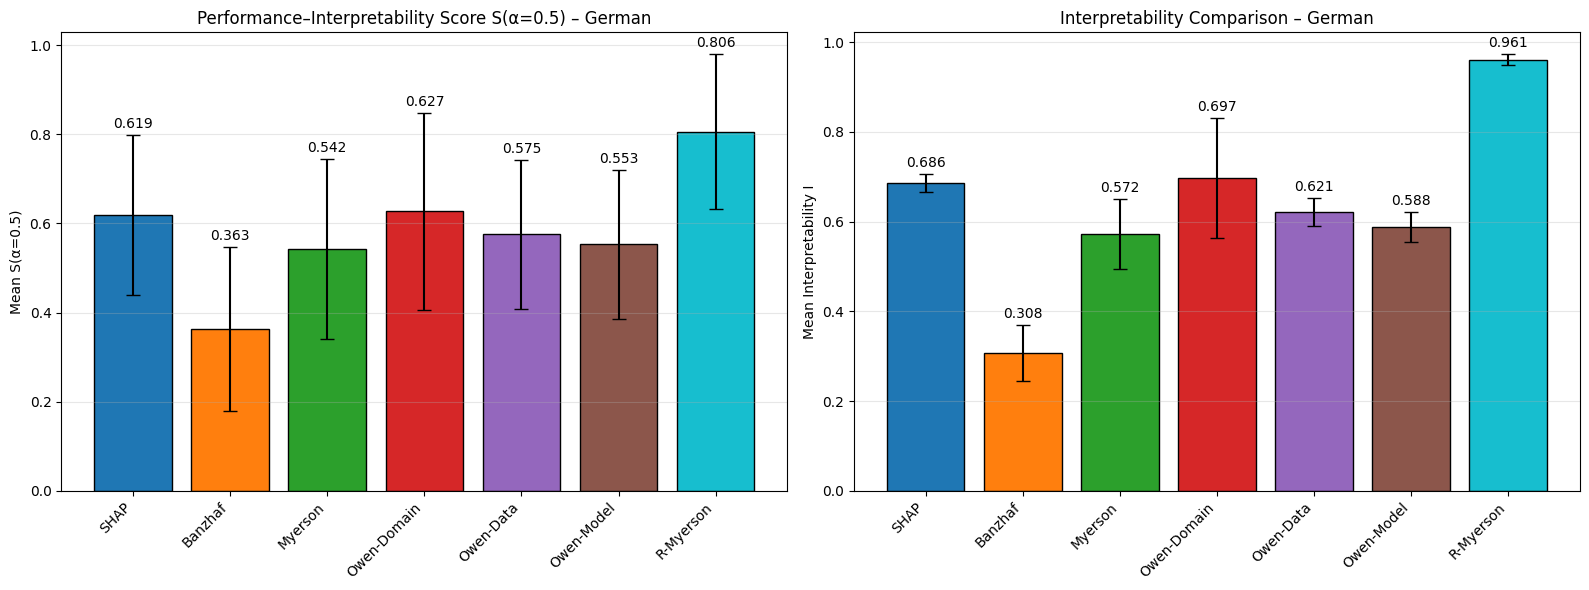

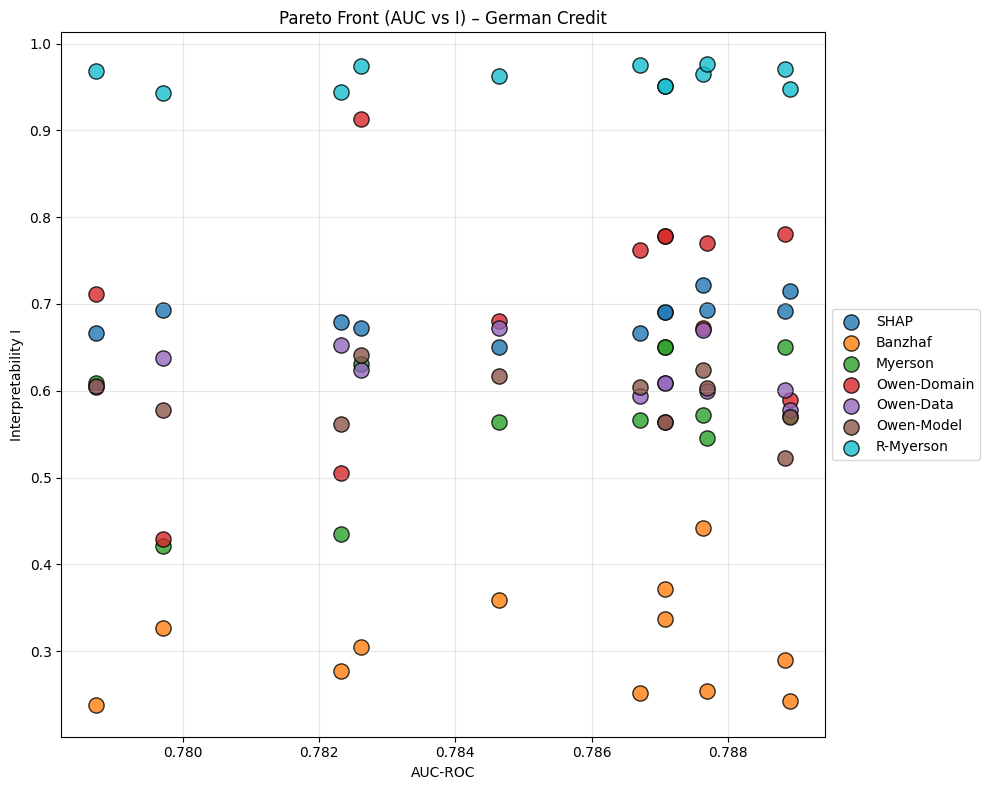

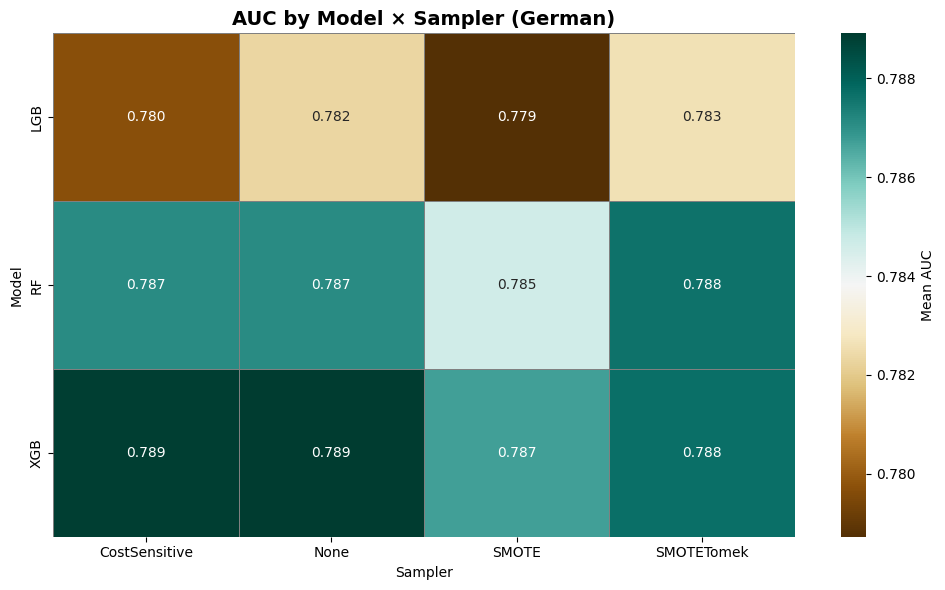

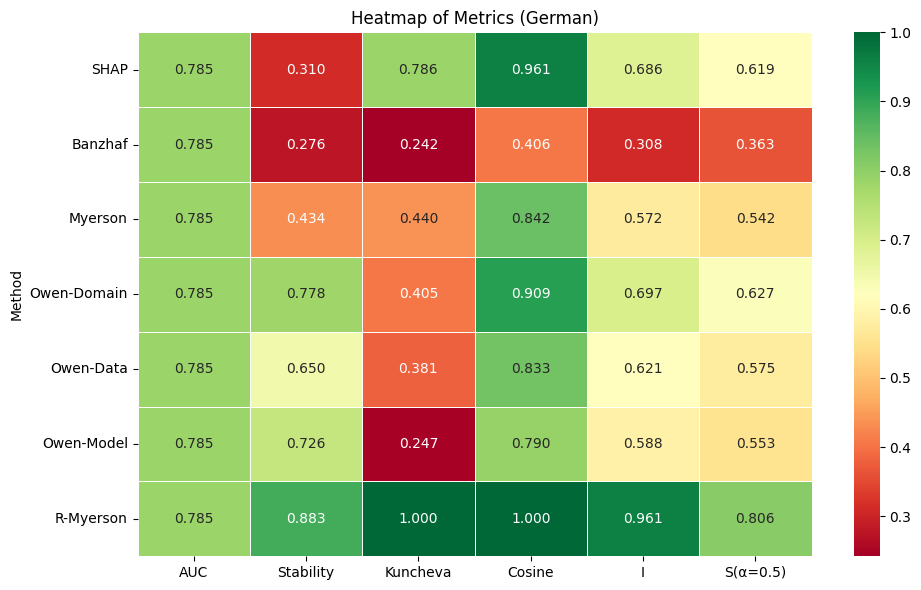

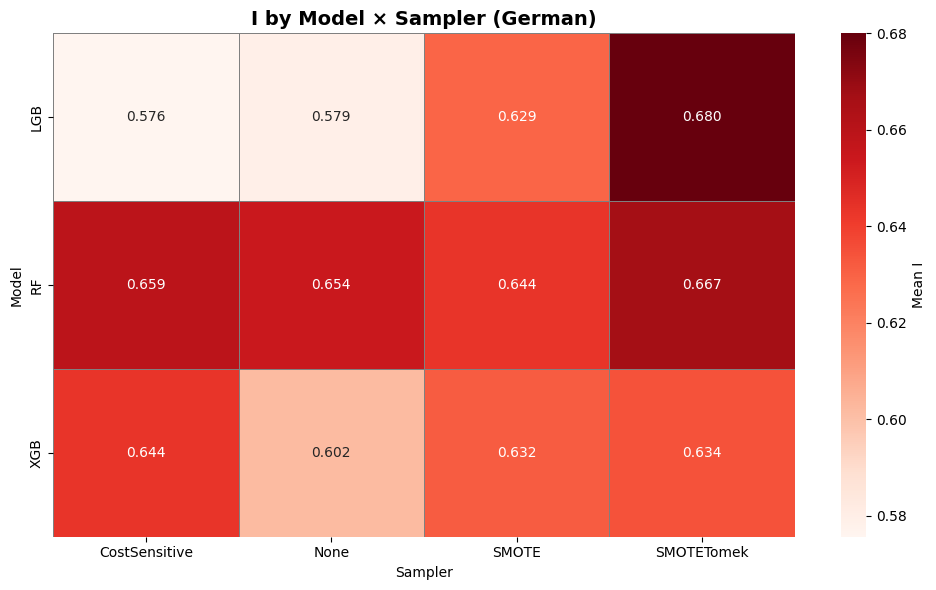

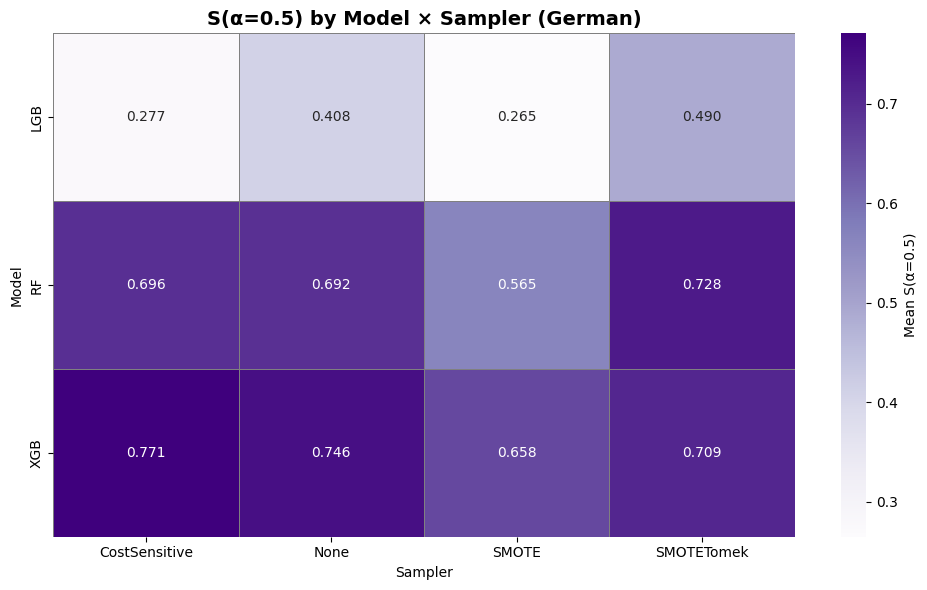

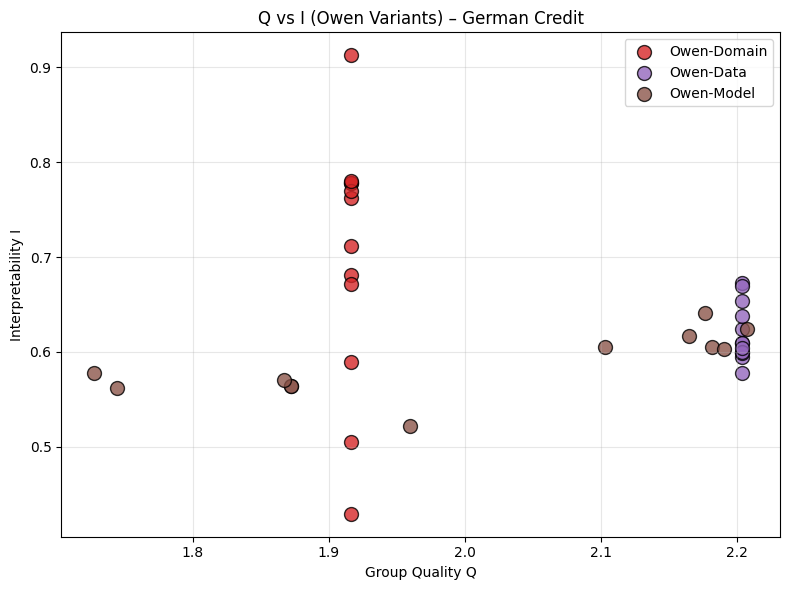

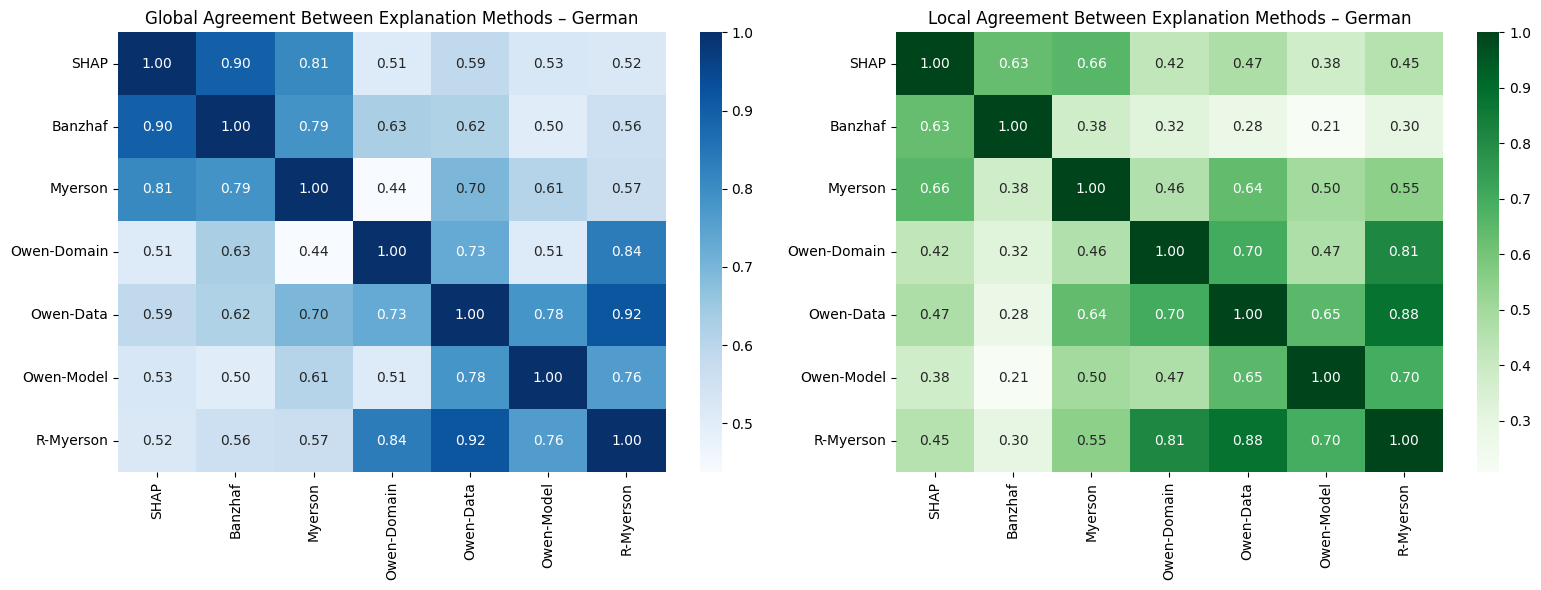


Global Agreement Matrix:
                 SHAP   Banzhaf   Myerson  Owen-Domain  Owen-Data  Owen-Model  \
SHAP         1.000000  0.895475  0.808085     0.511021   0.588442    0.526178   
Banzhaf      0.895475  1.000000  0.785223     0.626972   0.616345    0.502785   
Myerson      0.808085  0.785223  1.000000     0.437653   0.696369    0.607223   
Owen-Domain  0.511021  0.626972  0.437653     1.000000   0.729317    0.511940   
Owen-Data    0.588442  0.616345  0.696369     0.729317   1.000000    0.781810   
Owen-Model   0.526178  0.502785  0.607223     0.511940   0.781810    1.000000   
R-Myerson    0.520385  0.556470  0.565243     0.835861   0.917202    0.764542   

             R-Myerson  
SHAP          0.520385  
Banzhaf       0.556470  
Myerson       0.565243  
Owen-Domain   0.835861  
Owen-Data     0.917202  
Owen-Model    0.764542  
R-Myerson     1.000000  

Local Agreement Matrix:
                 SHAP   Banzhaf   Myerson  Owen-Domain  Owen-Data  Owen-Model  \
SHAP         1.0000

In [2]:
# ============================================================
# 9. VISUALIZATIONS (GERMAN – SAME STYLE AS COURSERA)
# ============================================================

method_colors = {
    'SHAP':        '#1f77b4',
    'Banzhaf':     '#ff7f0e',
    'Myerson':     '#2ca02c',
    'Owen-Domain': '#d62728',
    'Owen-Data':   '#9467bd',
    'Owen-Model':  '#8c564b',
    'R-Myerson':   '#17becf'
}

model_colors = {
    'RF': '#4C72B0',
    'XGB': '#DD8452',
    'LGB': '#55A868'
}

sampler_colors = {
    'None':          '#5A5A5A',
    'SMOTE':         '#5A3E2B',
    'SMOTETomek':    '#1F3B73',
    'CostSensitive': '#5A2E8A'
}

methods = method_order

# S(alpha) and I barplots
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# S(alpha)
ax = axes[0]
S_means = metrics.groupby("Method")["S(α=0.5)"].mean().reindex(methods)
S_stds  = metrics.groupby("Method")["S(α=0.5)"].std().reindex(methods)

bars = ax.bar(
    S_means.index, S_means.values,
    yerr=S_stds.values,
    color=[method_colors[m] for m in S_means.index],
    edgecolor='black', capsize=5
)

ax.bar_label(bars, fmt="%.3f", padding=3)
ax.set_xticklabels(S_means.index, rotation=45, ha='right')
ax.set_ylabel("Mean S(α=0.5)")
ax.set_title("Performance–Interpretability Score S(α=0.5) – German")
ax.grid(axis='y', alpha=0.3)

# I
ax = axes[1]
I_means = metrics.groupby("Method")["I"].mean().reindex(methods)
I_stds  = metrics.groupby("Method")["I"].std().reindex(methods)

bars = ax.bar(
    I_means.index, I_means.values,
    yerr=I_stds.values,
    color=[method_colors[m] for m in I_means.index],
    edgecolor='black', capsize=5
)

ax.bar_label(bars, fmt="%.3f", padding=3)
ax.set_xticklabels(I_means.index, rotation=45, ha='right')
ax.set_ylabel("Mean Interpretability I")
ax.set_title("Interpretability Comparison – German")
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig("german_plot1_2_side_by_side.png", dpi=150)
plt.show()

# Pareto front AUC vs I
plt.figure(figsize=(10, 8))
for method in methods:
    sub = metrics[metrics['Method'] == method]
    plt.scatter(sub['AUC'], sub['I'],
                s=120, label=method,
                color=method_colors[method],
                alpha=0.8, edgecolors='black')
plt.xlabel("AUC-ROC")
plt.ylabel("Interpretability I")
plt.title("Pareto Front (AUC vs I) – German Credit")
plt.grid(alpha=0.3)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
plt.tight_layout()
plt.savefig('german_plot3_pareto.png', dpi=150)
plt.show()

# AUC heatmap Model × Sampler
plt.figure(figsize=(10, 6))
auc_pivot = metrics.pivot_table(
    values='AUC',
    index='Model',
    columns='Sampler',
    aggfunc='mean'
).fillna(0)

sns.heatmap(
    auc_pivot,
    annot=True,
    fmt=".3f",
    cmap="BrBG",
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Mean AUC'}
)

plt.title("AUC by Model × Sampler (German)", fontsize=14, fontweight='bold')
plt.xlabel("Sampler")
plt.ylabel("Model")
plt.tight_layout()
plt.savefig("german_plot4_auc_heatmap.png", dpi=150)
plt.show()

# Heatmap of metrics
plt.figure(figsize=(10, 6))
heatmap_data = metrics.groupby("Method")[['AUC', 'Stability', 'Kuncheva', 'Cosine', 'I', 'S(α=0.5)']].mean().reindex(methods)
sns.heatmap(heatmap_data, annot=True, fmt='.3f', cmap='RdYlGn', linewidths=0.5)
plt.title("Heatmap of Metrics (German)")
plt.tight_layout()
plt.savefig('german_plot7_heatmap.png', dpi=150)
plt.show()

# I heatmap Model × Sampler
plt.figure(figsize=(10, 6))
I_pivot = metrics.pivot_table(
    values='I',
    index='Model',
    columns='Sampler',
    aggfunc='mean'
).fillna(0)

sns.heatmap(
    I_pivot,
    annot=True,
    fmt=".3f",
    cmap="Reds",
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Mean I'}
)

plt.title("I by Model × Sampler (German)", fontsize=14, fontweight='bold')
plt.xlabel("Sampler")
plt.ylabel("Model")
plt.tight_layout()
plt.savefig("german_I_heatmap.png", dpi=150)
plt.show()

# S(alpha) heatmap Model × Sampler
plt.figure(figsize=(10, 6))
S_pivot = metrics.pivot_table(
    values='S(α=0.5)',
    index='Model',
    columns='Sampler',
    aggfunc='mean'
).fillna(0)

sns.heatmap(
    S_pivot,
    annot=True,
    fmt=".3f",
    cmap="Purples",
    linewidths=0.5,
    linecolor='gray',
    cbar_kws={'label': 'Mean S(α=0.5)'}
)

plt.title("S(α=0.5) by Model × Sampler (German)", fontsize=14, fontweight='bold')
plt.xlabel("Sampler")
plt.ylabel("Model")
plt.tight_layout()
plt.savefig("german_S_heatmap.png", dpi=150)
plt.show()

# Q vs I for Owen variants
plt.figure(figsize=(8, 6))
owen_methods = ['Owen-Domain', 'Owen-Data', 'Owen-Model']
Q_means = metrics[metrics['Method'].isin(owen_methods)].groupby('Method')['Q'].mean().reindex(owen_methods)
for method in owen_methods:
    sub = metrics[metrics['Method'] == method]
    plt.scatter(sub['Q'], sub['I'],
                s=100, label=method,
                color=method_colors[method],
                alpha=0.8, edgecolors='black')
plt.xlabel("Group Quality Q")
plt.ylabel("Interpretability I")
plt.title("Q vs I (Owen Variants) – German Credit")
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.savefig('german_plot9_q_vs_i.png', dpi=150)
plt.show()

# ============================================================
# GLOBAL & LOCAL AGREEMENT
# ============================================================

def compute_global_local_agreement(all_explanations, methods):
    method_names = methods
    M = len(method_names)

    # Global
    mean_vectors = []
    for method in method_names:
        all_runs = []
        for (mname, sname), method_dict in all_explanations.items():
            all_runs.extend(method_dict[method])
        vec = np.mean([np.abs(e).mean(axis=0) for e in all_runs], axis=0)
        mean_vectors.append(vec)

    G = np.zeros((M, M))
    for i in range(M):
        for j in range(M):
            G[i, j] = 1 - cosine(mean_vectors[i], mean_vectors[j])

    # Local
    L = np.zeros((M, M))
    all_runs = [method_dict for (_, _), method_dict in all_explanations.items()]

    for i, mi in enumerate(method_names):
        for j, mj in enumerate(method_names):
            sims = []
            for run in all_runs:
                Ei_list = run[mi]
                Ej_list = run[mj]
                for Ei, Ej in zip(Ei_list, Ej_list):
                    for vi, vj in zip(Ei, Ej):
                        sims.append(1 - cosine(np.abs(vi), np.abs(vj)))
            L[i, j] = np.mean(sims)

    fig, axes = plt.subplots(1, 2, figsize=(16, 6))

    sns.heatmap(
        G, annot=True, cmap="Blues",
        xticklabels=method_names, yticklabels=method_names,
        fmt=".2f", ax=axes[0]
    )
    axes[0].set_title("Global Agreement Between Explanation Methods – German")

    sns.heatmap(
        L, annot=True, cmap="Greens",
        xticklabels=method_names, yticklabels=method_names,
        fmt=".2f", ax=axes[1]
    )
    axes[1].set_title("Local Agreement Between Explanation Methods – German")

    plt.tight_layout()
    plt.show()

    print("\nGlobal Agreement Matrix:")
    print(pd.DataFrame(G, index=method_names, columns=method_names))

    print("\nLocal Agreement Matrix:")
    print(pd.DataFrame(L, index=method_names, columns=method_names))

compute_global_local_agreement(all_explanations, methods)

# ============================================================
#  STATISTICAL ANALYSIS (FRIEDMAN, NEMENYI, WILCOXON, CORR)
# ============================================================

print("\n==================== STATISTICAL ANALYSIS – GERMAN ====================\n")

results_full = pd.read_csv("german_results_7methods.csv")
alpha = 0.05

def tick(p):
    return "✓" if p < alpha else "✗"

def effect_label(delta):
    d_abs = abs(delta)
    if d_abs < 0.147:
        return "negligible"
    elif d_abs < 0.33:
        return "small"
    elif d_abs < 0.474:
        return "medium"
    else:
        return "large"

def cliffs_delta(x, y):
    x = np.array(x)
    y = np.array(y)
    x = x[~np.isnan(x)]
    y = y[~np.isnan(y)]
    n1 = len(x)
    n2 = len(y)
    if n1 == 0 or n2 == 0:
        return np.nan
    diffs = x.reshape(-1, 1) - y.reshape(1, -1)
    n_greater = np.sum(diffs > 0)
    n_less = np.sum(diffs < 0)
    return (n_greater - n_less) / (n1 * n2)

pivot_T = results_full.pivot_table(
    values='S(α=0.5)',
    index=['Model', 'Sampler'],
    columns='Method'
)

complete_methods = pivot_T.dropna(axis=1).columns.tolist()
print("Methods included:", complete_methods, "\n")

print("=== Friedman Test ===")
fried_stat, fried_p = friedmanchisquare(
    *[pivot_T[m].values for m in complete_methods]
)
print(f"χ²={fried_stat:.4f}, p={fried_p:.6f} {tick(fried_p)}\n")

if fried_p < alpha:
    print("=== Nemenyi Post-hoc ===")
    nemenyi_p = sp.posthoc_nemenyi_friedman(pivot_T[complete_methods].values)
    nemenyi_p.index = complete_methods
    nemenyi_p.columns = complete_methods
    print(nemenyi_p)
    nemenyi_p.to_csv("german_nemenyi_results.csv")
else:
    print("Friedman not significant → skipping Nemenyi.\n")

print("\n=== Wilcoxon + Cliff's Delta ===")
rows = []
for i in range(len(complete_methods)):
    for j in range(i + 1, len(complete_methods)):
        m1, m2 = complete_methods[i], complete_methods[j]
        x = pivot_T[m1].values
        y = pivot_T[m2].values
        stat, p = wilcoxon(x, y)
        delta = cliffs_delta(x, y)
        rows.append({
            'Method1': m1,
            'Method2': m2,
            'Wilcoxon_stat': stat,
            'p_value': p,
            'Significant': tick(p),
            "Cliff's_delta": delta,
            'Effect_size': effect_label(delta)
        })

wilcoxon_df = pd.DataFrame(rows)
print(wilcoxon_df)
wilcoxon_df.to_csv("german_wilcoxon_cliffs_results.csv", index=False)

print("\n=== Correlation AUC vs I ===")
rho_s, p_s = spearmanr(results_full['AUC'], results_full['I'])
tau_k, p_k = kendalltau(results_full['AUC'], results_full['I'])

print(f"Spearman ρ={rho_s:.3f}, p={p_s:.6f} {tick(p_s)}")
print(f"Kendall τ={tau_k:.3f}, p={p_k:.6f} {tick(p_k)}")

pd.DataFrame([{
    'Spearman_rho': rho_s,
    'Spearman_p': p_s,
    'Kendall_tau': tau_k,
    'Kendall_p': p_k
}]).to_csv("german_auc_I_correlation.csv", index=False)

print("\n✓ Statistical analysis complete (German).\n")
